In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

## Clasificación

Existen dos formas básicas de clasificar las opciones asiáticas.

### Según el tipo de promedio usado

- *Usando el promedio/media aritmética*
  - Es el más común. Usa la media aritmética de los precios del activo subyacente.

- *Usando la media geométrica*
  - Es menos común. Usa la media geométrica de los precios del activo subyacente.

### Según cómo se aplica el promedio

- *Average Price o Fixed Strike:*  
  El Precio Strike es fijo y el Payoff se usa calculando el precio promedio del subyacente.

  $$\text{Payoff} = \max(\bar{S} - K, 0)$$

- *Average Strike o Floating Strike:*  
  El Strike no se conoce al pactar el contrato. Más bien el Strike es el precio promedio del subyacente y se compara con \( S_T \) (el precio del activo al vencimiento).

  $$\text{Payoff} = \max(S_T - \bar{S}, 0)$$

In [17]:
ticker = 'CL=F' # WTI Crude Oil

data = yf.download(ticker, start='2022-01-01', end='2025-10-15', progress=False)['Close']

S0 = data.iloc[-1]  # Precio inicial
S0

C:\Users\samue\AppData\Local\Temp\ipykernel_10140\1253871904.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2022-01-01', end='2025-10-15', progress=False)['Close']


Ticker
CL=F    58.27
Name: 2025-10-15 00:00:00, dtype: float64

In [18]:
returns = data.pct_change().dropna()
sigma = returns.std() * np.sqrt(252)  # Volatilidad anualizada
T = 1
K = 65
num_steps = 252
r = 0.0425
n_sims = 10000
dt = T / num_steps
Z = np.random.standard_normal(size=(n_sims, num_steps))

In [19]:
def simulate_prices(S0, r, sigma, T, num_steps, n_sims):
    dt = T / num_steps                         # tamaño del paso temporal
    Z = np.random.normal(size=(n_sims, num_steps))  # shocks aleatorios ~ N(0,1)
    simulated_returns = (r - 0.5 * sigma.iloc[0]**2) * dt + sigma.iloc[0] * np.sqrt(dt) * Z
    simulated_cumulative_returns = np.cumsum(simulated_returns, axis=1)
    simulated_prices = S0.iloc[0] * np.exp(simulated_cumulative_returns)
    return simulated_prices

In [20]:
def get_price_fixed_strike_average_price(simulated_prices, K, r, T, option_type):
    avg_prices = np.mean(simulated_prices[:, 1:], axis=1)
    
    if option_type == 'call':
        payoffs = np.maximum(avg_prices - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - avg_prices, 0)

    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

In [21]:
def get_price_floating_strike_average_price(simulated_prices, r, T, option_type):
    avg_prices = np.mean(simulated_prices[:, 1:], axis=1)
    final_prices = simulated_prices[:, -1]
    
    if option_type == 'call':
        payoffs = np.maximum(final_prices - avg_prices, 0)
    elif option_type == 'put':
        payoffs = np.maximum(avg_prices - final_prices, 0)

    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

In [22]:
def get_price_fixed_strike_geometric_price(simulated_prices, K, r, T, option_type):
    geo_avg_prices = np.exp(np.mean(np.log(simulated_prices[:, 1:]), axis=1))

    if option_type == 'call':
        payoffs = np.maximum(geo_avg_prices - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - geo_avg_prices, 0)

    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

In [23]:
def get_price_floating_strike_geometric_price(simulated_prices, r, T, option_type):
    geo_avg_prices = np.exp(np.mean(np.log(simulated_prices[:, 1:]), axis=1))
    final_prices = simulated_prices[:, -1]

    if option_type == 'call':
        payoffs = np.maximum(final_prices - geo_avg_prices, 0)
    elif option_type == 'put':
        payoffs = np.maximum(geo_avg_prices - final_prices, 0)

    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

In [24]:
def get_price_european(simuated_prices, K, r, T, option_type):
    final_prices = simulated_prices[:, -1]

    if option_type == 'call':
        payoffs = np.maximum(final_prices - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - final_prices, 0)

    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

2. Compara los precios de las primas para una opción europea, opción asiática Fixed Strike con media aritmética y  opción asiática Fixed Strike con media geométrica.
- Grafica en el eje Y el precio de la prima y en X diferentes precios Strike. Observa los precios
- ¿Cuáles son las más baratas y las más caras?
- ¿Las más baratas sigue siendo la más baratas sin importar si es una opcion call o put?
- Piensa por qué son estos resultados e interpreta lo que ves

In [25]:
x = np.linspace(20, 100, 20)  # Diferentes precios strike

simulated_prices = simulate_prices(S0, r, sigma, T, num_steps, n_sims)

eropuean_call_prices = [get_price_european(simulated_prices, strike, r, T, 'call') for strike in x]
eropuean_put_prices = [get_price_european(simulated_prices, strike, r, T, 'put') for strike in x]

fixed_strike_average_call_prices = [get_price_fixed_strike_average_price(simulated_prices, strike, r, T, 'call') for strike in x]
fixed_strike_average_put_prices = [get_price_fixed_strike_average_price(simulated_prices, strike, r, T, 'put') for strike in x]

fixed_strike_geometric_call_prices = [get_price_fixed_strike_geometric_price(simulated_prices, strike, r, T, 'call') for strike in x]
fixed_strike_geometric_put_prices = [get_price_fixed_strike_geometric_price(simulated_prices, strike, r, T, 'put') for strike in x] 

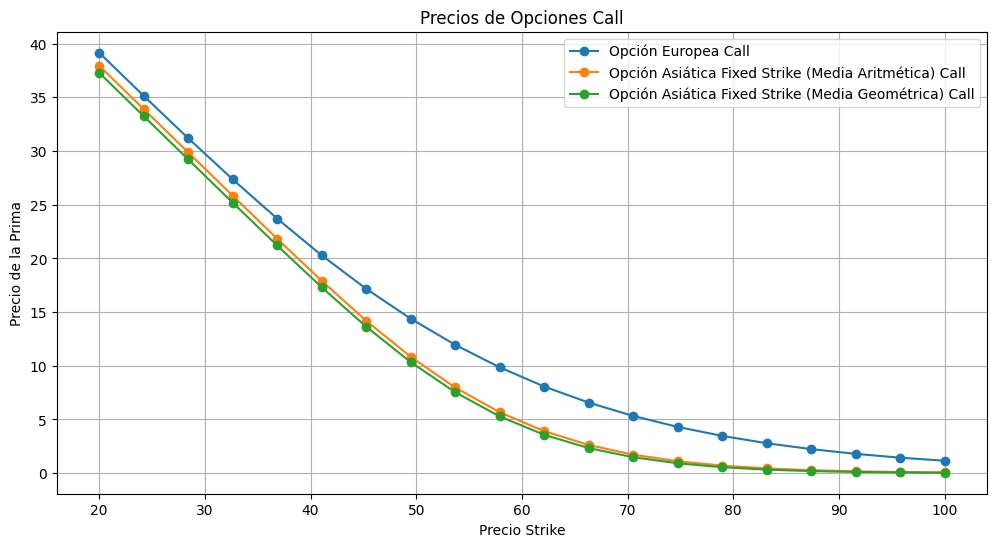

In [26]:
# Precios de opciones call
plt.figure(figsize=(12, 6))
plt.plot(x, eropuean_call_prices, label='Opción Europea Call', marker='o')
plt.plot(x, fixed_strike_average_call_prices, label='Opción Asiática Fixed Strike (Media Aritmética) Call', marker='o')
plt.plot(x, fixed_strike_geometric_call_prices, label='Opción Asiática Fixed Strike (Media Geométrica) Call', marker='o')
plt.xlabel('Precio Strike')
plt.ylabel('Precio de la Prima')
plt.title('Precios de Opciones Call')
plt.legend()
plt.grid()
plt.show()

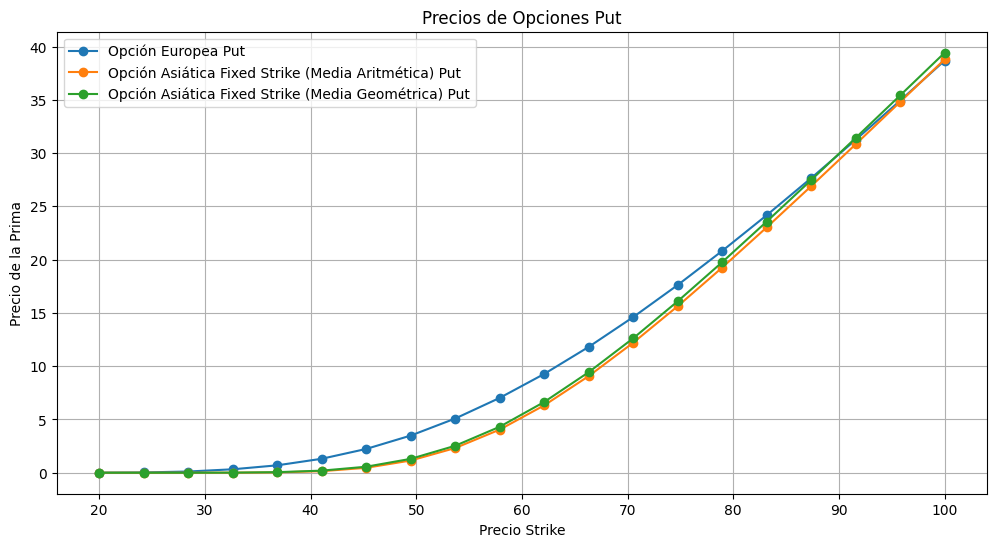

In [27]:
# Precios de opciones put
plt.figure(figsize=(12, 6))
plt.plot(x, eropuean_put_prices, label='Opción Europea Put', marker='o')
plt.plot(x, fixed_strike_average_put_prices, label='Opción Asiática Fixed Strike (Media Aritmética) Put', marker='o')
plt.plot(x, fixed_strike_geometric_put_prices, label='Opción Asiática Fixed Strike (Media Geométrica) Put', marker='o')
plt.xlabel('Precio Strike')
plt.ylabel('Precio de la Prima')
plt.title('Precios de Opciones Put')
plt.legend()
plt.grid()
plt.show()

Al comparar los precios de las primas, se observa que las opciones europeas presentan los valores más altos, seguidas por las opciones asiáticas con media aritmética, mientras que las opciones asiáticas con media geométrica resultan ser las más económicas. Este comportamiento se mantiene tanto para las opciones Call como para las Put, evidenciando que el método de cálculo del promedio influye directamente en el valor de la prima.

La diferencia se explica porque las opciones asiáticas reducen la volatilidad efectiva al considerar un promedio de precios en lugar de un valor final. En particular, la media geométrica suaviza aún más las variaciones extremas, disminuyendo el riesgo y, por tanto, el valor esperado del payoff. En consecuencia, las opciones asiáticas ofrecen una cobertura más estable, pero con un costo menor en comparación con las opciones europeas.

3. Usando simulated prices, obtén el ST promedio.  Con ese ST, calcula los precios de las opciones Floating Strike. Compara los precios vs las Fixed Strike y la europea. 

- ¿Cuáles son las más baratas y las más caras?
- ¿Las más baratas sigue siendo la más baratas sin importar si es una opcion call o put?
- Piensa por qué son estos resultados e interpreta lo que ves 

In [28]:
floating_strike_average_call_prices = get_price_floating_strike_average_price(simulated_prices, r, T, 'call')
floating_strike_average_put_prices = get_price_floating_strike_average_price(simulated_prices, r, T, 'put')

floating_strike_geometric_call_prices = get_price_floating_strike_geometric_price(simulated_prices, r, T, 'call')
floating_strike_geometric_put_prices = get_price_floating_strike_geometric_price(simulated_prices, r, T, 'put')

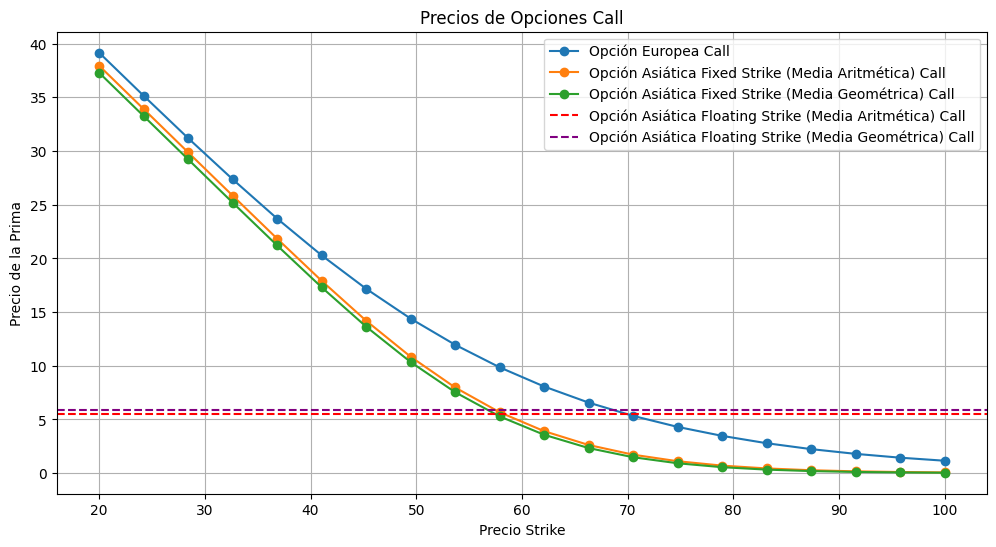

In [29]:
# Opciones Call
plt.figure(figsize=(12, 6))
plt.plot(x, eropuean_call_prices, label='Opción Europea Call', marker='o')
plt.plot(x, fixed_strike_average_call_prices, label='Opción Asiática Fixed Strike (Media Aritmética) Call', marker='o')
plt.plot(x, fixed_strike_geometric_call_prices, label='Opción Asiática Fixed Strike (Media Geométrica) Call', marker='o')

plt.axhline(y=floating_strike_average_call_prices, color='r', linestyle='--', label='Opción Asiática Floating Strike (Media Aritmética) Call')
plt.axhline(y=floating_strike_geometric_call_prices, color='purple', linestyle='--', label='Opción Asiática Floating Strike (Media Geométrica) Call')

plt.xlabel('Precio Strike')
plt.ylabel('Precio de la Prima')
plt.title('Precios de Opciones Call')
plt.legend()
plt.grid()
plt.show()

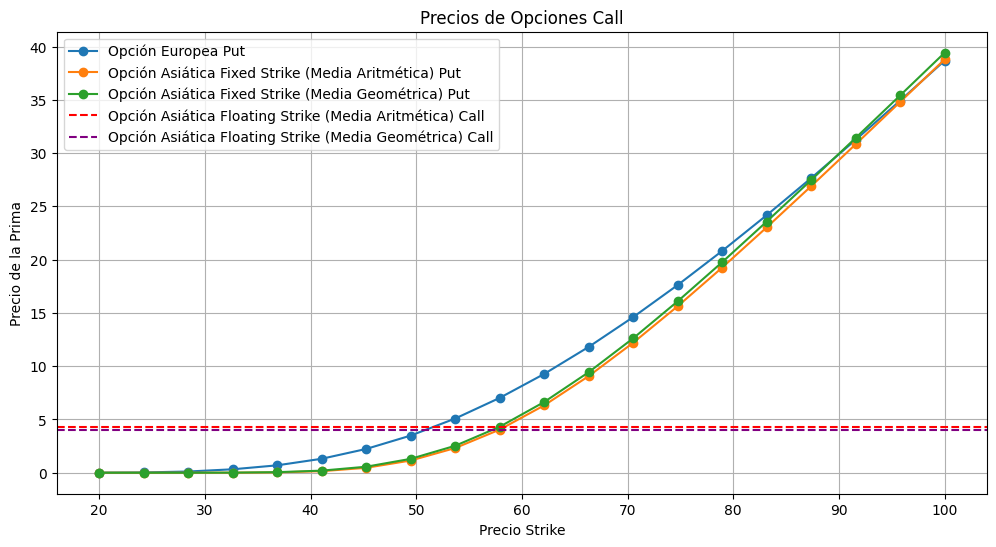

In [30]:
# Opciones Put
plt.figure(figsize=(12, 6))
plt.plot(x, eropuean_put_prices, label='Opción Europea Put', marker='o')
plt.plot(x, fixed_strike_average_put_prices, label='Opción Asiática Fixed Strike (Media Aritmética) Put', marker='o')
plt.plot(x, fixed_strike_geometric_put_prices, label='Opción Asiática Fixed Strike (Media Geométrica) Put', marker='o')

plt.axhline(y=floating_strike_average_put_prices, color='r', linestyle='--', label='Opción Asiática Floating Strike (Media Aritmética) Call')
plt.axhline(y=floating_strike_geometric_put_prices, color='purple', linestyle='--', label='Opción Asiática Floating Strike (Media Geométrica) Call')

plt.xlabel('Precio Strike')
plt.ylabel('Precio de la Prima')
plt.title('Precios de Opciones Call')
plt.legend()
plt.grid()
plt.show()

Los resultados muestran que las opciones europeas siguen siendo las más caras, seguidas por las opciones asiáticas Fixed Strike, mientras que las opciones asiáticas Floating Strike son las más baratas. Sin embargo, se observa un comportamiento particular: en las opciones Call, las Floating Strike mantienen el menor precio hasta que el precio del strike se aproxima al valor promedio del subyacente, punto en el cual sus primas igualan o superan ligeramente a las Fixed Strike. En cambio, en las opciones Put, sucede lo opuesto: las Floating Strike son más baratas hasta que el strike se iguala al promedio, momento a partir del cual las Fixed Strike se vuelven marginalmente más económicas.

Este comportamiento se explica porque el strike flotante se ajusta al nivel promedio del activo, reduciendo la volatilidad efectiva y el valor esperado del payoff. Cuando el strike fijo y el promedio convergen, la diferencia en el riesgo residual se minimiza, haciendo que ambas opciones tiendan a tener precios similares. En consecuencia, las Floating Strike suelen ofrecer la prima más baja mientras el strike difiera del promedio, reflejando una menor exposición al riesgo de precios extremos.